In [100]:
import  mne
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from numpy import ndarray
from scipy.stats import pearsonr
import numpy as np
from joblib import Parallel, delayed
from scipy.sparse import block_diag, identity, vstack, spmatrix
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh, pinv, qr
from typing import Optional, List, cast
from functools import partial

Opening raw data file E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230505_concurrent\sunsun_20230505_concurrent.fif...
    Range : 0 ... 242373 =      0.000 ...   969.492 secs
Ready.
Reading 0 ... 242373  =      0.000 ...   969.492 secs...
Creating RawArray with float64 data, n_channels=9, n_times=237374
    Range : 0 ... 237373 =      0.000 ...   949.492 secs
Ready.
Effective window size : 1.024 (s)


C:\Users\Sunsun\AppData\Local\Temp\ipykernel_1188\896483423.py:3: RuntimeWarning: This filename (E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230505_concurrent\sunsun_20230505_concurrent.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fname,  preload = True)
c:\Users\Sunsun\.virtualenvs\HybridSpeller-q8UBACmb\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


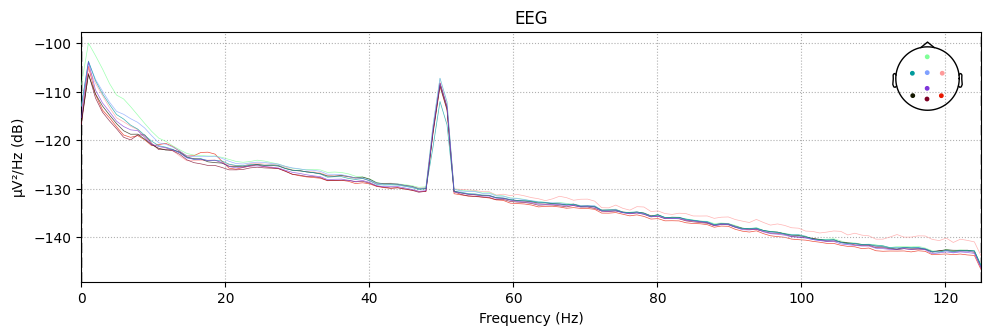

In [101]:
fname = r"E:\Thesis\HybridSpeller\nine_flicker\record\sunsun_20230505_concurrent\sunsun_20230505_concurrent.fif"

raw =  mne.io.read_raw_fif(fname,  preload = True)
new_data = raw.get_data()[:,10*250:-10*250]
new_data[:8,:]  = new_data[:8,:] * 1e-6
raw = mne.io.RawArray(new_data, raw.info)


# b,a = signal.iirfilter(10, Wn=[7, 90],  btype='band', analog=False, fs=250,  ftype='butter')

# filt = signal.filtfilt(b,a,x,axis=1)

# raw_new.notch_filter([50,100], trans_bandwidth = 3)
# raw_new.filter(4,77)
# raw_new.compute_psd().plot()
# raw.notch_filter([50], trans_bandwidth = 3)
# raw.filter(7,90)
raw.compute_psd().plot()

In [102]:
events = mne.find_events(raw, initial_event = True)
tmin, tmax = 1, 5 - 1/250  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)


X = epochs.get_data()[:, :-1, :]
y = epochs.events[:, -1]

135 events found
Event IDs: [1 2 3 4 5 6 7 8 9]
Using data from preloaded Raw for 135 events and 1000 original time points ...
0 bad epochs dropped


In [103]:
wp=[(1,90),(11,90),(22,90),(34,90),(46,90),(58,90),(70,90),(82,90)]
ws=[(3,92),(12,92),(20,92),(28,92),(36,92), (44,92), (52,92),(60,92)]

In [104]:
from typing import Optional, List, Tuple, Union
from scipy.signal import sosfiltfilt, cheby1, cheb1ord

class FilterBank(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        base_estimator: BaseEstimator,
        filterbank: List[ndarray],
        n_jobs: Optional[int] = None,
    ):
        self.base_estimator = base_estimator
        self.filterbank = filterbank
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: Optional[ndarray] = None, **kwargs):
        self.estimators_ = [
            clone(self.base_estimator) for _ in range(len(self.filterbank))
        ]
        X = self.transform_filterbank(X)
        for i, est in enumerate(self.estimators_):
            est.fit(X[i], y, **kwargs)
        # def wrapper(est, X, y, kwargs):
        #     est.fit(X, y, **kwargs)
        #     return est
        # self.estimators_ = Parallel(n_jobs=self.n_jobs)(
        #     delayed(wrapper)(est, X[i], y, kwargs) for i, est in enumerate(self.estimators_))
        return self

    def transform(self, X: ndarray, **kwargs):
        X = self.transform_filterbank(X)
        feat = [est.transform(X[i], **kwargs) for i, est in enumerate(self.estimators_)]
        # def wrapper(est, X, kwargs):
        #     retval = est.transform(X, **kwargs)
        #     return retval
        # feat = Parallel(n_jobs=self.n_jobs)(
        #     delayed(wrapper)(est, X[i], kwargs) for i, est in enumerate(self.estimators_))
        feat = np.concatenate(feat, axis=-1)
        return feat

    def transform_filterbank(self, X: ndarray):
        Xs = np.stack([sosfiltfilt(sos, X, axis=-1) for sos in self.filterbank])
        return Xs
    
class FilterBankSSVEP(FilterBank):
    """Filter bank analysis for SSVEP."""

    def __init__(
        self,
        filterbank: List[ndarray],
        base_estimator: BaseEstimator,
        filterweights: Optional[ndarray] = None,
        n_jobs: Optional[int] = None,
    ):
        self.filterweights = filterweights
        super().__init__(base_estimator, filterbank, n_jobs=n_jobs)

    def transform(self, X: ndarray):  # type: ignore[override]
        features = super().transform(X)
        if self.filterweights is None:
            return features
        else:
            features = np.reshape(
                features, (features.shape[0], len(self.filterbank), -1)
            )
            return np.sum(
                features * self.filterweights[np.newaxis, :, np.newaxis], axis=1
            )

def generate_filterbank(
    passbands: List[Tuple[float, float]],
    stopbands: List[Tuple[float, float]],
    srate: int,
    order: Optional[int] = None,
    rp: float = 0.5,
):
    filterbank = []
    for wp, ws in zip(passbands, stopbands):
        if order is None:
            N, wn = cheb1ord(wp, ws, 3, 40, fs=srate)
            sos = cheby1(N, rp, wn, btype="bandpass", output="sos", fs=srate)
        else:
            sos = cheby1(order, rp, wp, btype="bandpass", output="sos", fs=srate)

        filterbank.append(sos)
    return filterbank

In [105]:
filterbank = generate_filterbank(wp,ws,srate=250,order=15,rp=0.5)

In [106]:
filterweights = [(idx_filter+1) ** (-1.25) + 0.25 for idx_filter in range(8)]

In [107]:
def _ged_wong(
    Z: ndarray,
    D: Optional[ndarray] = None,
    P: Optional[ndarray] = None,
    n_components=1,
    method="type1",
):
    if method != "type1" and method != "type2":
        raise ValueError("not supported method type")

    A = Z
    if D is not None:
        A = D.T @ A
    if P is not None:
        A = P.T @ A
    A = A.T @ A
    if method == "type1":
        B = Z
        if D is not None:
            B = D.T @ Z
        B = B.T @ B
        if isinstance(A, spmatrix) or isinstance(B, spmatrix):
            D, W = eigsh(A, k=n_components, M=B)
        else:
            D, W = eigh(A, B)
    elif method == "type2":
        if isinstance(A, spmatrix):
            D, W = eigsh(A, k=n_components)
        else:
            D, W = eigh(A)

    D_exist = cast(ndarray, D)
    ind = np.argsort(D_exist)[::-1]
    D_exist, W = D_exist[ind], W[:, ind]
    return D_exist[:n_components], W[:, :n_components]

def _trca_kernel(X: ndarray):
    """TRCA.
    X: (n_trials, n_channels, n_samples)
    """
    X = np.reshape(X, (-1, *X.shape[-2:]))
    M, C, N = X.shape
    n_components = C
    P = vstack([identity(N) for _ in range(M)])
    P = P @ P.T
    Z = np.hstack(X).T  # type: ignore
    _, U = _ged_wong(Z, None, P, n_components=n_components)  # U for X
    return U

def _trca_feature(
    X: ndarray,
    templates: ndarray,
    Us: ndarray,
    n_components: int = 1,
    ensemble: bool = True,
):
    rhos = []
    if not ensemble:
        for Xk, U in zip(templates, Us):
            a = U[:, :n_components].T @ X
            b = U[:, :n_components].T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    else:
        U = Us[:, :, :n_components]
        U = np.concatenate(U, axis=-1)
        for Xk in templates:
            a = U.T @ X
            b = U.T @ Xk
            a = np.reshape(a, (-1))
            b = np.reshape(b, (-1))
            rhos.append(pearsonr(a, b)[0])
    return rhos

class TRCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(
        self, n_components: int = 1, ensemble: bool = True, n_jobs: Optional[int] = None
    ):
        self.n_components = n_components
        self.ensemble = ensemble
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        self.templates_ = np.stack(
            [np.mean(X[y == label], axis=0) for label in self.classes_]
        )

        self.Us_ = np.stack([_trca_kernel(X[y == label])
                            for label in self.classes_])
        return self

    def transform(self, X: ndarray):
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        n_components = self.n_components
        templates = self.templates_
        Us = self.Us_
        ensemble = self.ensemble
        rhos = Parallel(n_jobs=self.n_jobs)(
            delayed(
                partial(
                    _trca_feature, Us=Us, n_components=n_components, ensemble=ensemble
                )
            )(a, templates)
            for a in X
        )
        rhos = np.stack(rhos)
        return rhos

    def predict(self, X: ndarray):
        feat = self.transform(X)
        labels = self.classes_[np.argmax(feat, axis=-1)]
        return labels
    
class FBTRCA(FilterBankSSVEP, ClassifierMixin):
    def __init__(
        self,
        filterbank: List[ndarray],
        n_components: int = 1,
        ensemble: bool = True,
        filterweights: Optional[ndarray] = None,
        n_jobs: Optional[int] = None,
    ):
        self.n_components = n_components
        self.ensemble = ensemble
        self.filterweights = filterweights
        self.n_jobs = n_jobs
        super().__init__(
            filterbank,
            TRCA(n_components=n_components, ensemble=ensemble, n_jobs=1),
            filterweights=filterweights,
            n_jobs=n_jobs,
        )

    # type: ignore[override]
    def fit(self, X: ndarray, y: ndarray, Yf: Optional[ndarray] = None):
        self.classes_ = np.unique(y)
        super().fit(X, y, Yf=Yf)
        return self

    def predict(self, X: ndarray):
        features = self.transform(X)
        if self.filterweights is None:
            features = np.reshape(
                features, (features.shape[0], len(self.filterbank), -1)
            )
            features = np.mean(features, axis=1)
        labels = self.classes_[np.argmax(features, axis=-1)]
        return labels

In [108]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
print(skf)
accs = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: ", y[train_index])
    print(f"  Test: ", y[test_index])
    model=FBTRCA(filterbank=filterbank,n_components = 1, ensemble = True,filterweights=np.array(filterweights), n_jobs=-1)
    model.fit(X[train_index], y[train_index])
    preds = model.predict(X[test_index])
    acc = np.mean(preds == y[test_index])
    accs.append(acc)
    print(y[test_index])
    print(preds)
    print(acc)
print("Average accuracy ==>", np.mean(accs))

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
Fold 0:
  Train:  [3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3
 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1
 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5]
  Test:  [3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5]
[3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5]
[3 4 4 2 6 6 4 9 6 4 1 4 9 9 4 6 6 5 3 5 7 7 6 8 6 6 5]
0.4444444444444444
Fold 1:
  Train:  [3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3
 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1
 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5]
  Test:  [3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5]
[3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5]
[7 9 4 9 9 4 6 2 5 7 4 1 7 1 8 6 3 5 3 1 1 7 7 8 8 2 3]
0.5185185185185185
Fold 2:
  Train:  [3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2 5 3 1 4 7 9 8 6 2